<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I2wUTT12p5bX3RCku_T_82aD4tkY9LVY" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов.

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>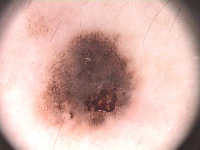</td><td>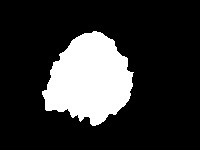</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
# !wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

# если по ссылке слишком много запросов, датасет можно скачать с kaggle: https://www.kaggle.com/datasets/kanametov/ph2dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
!unzip -q /content/gdrive/MyDrive/PH2Dataset.zip

Mounted at /content/gdrive/


In [ ]:
!ls

gdrive	PH2Dataset  sample_data


In [ ]:
# get_ipython().system_raw("unrar x PH2Dat|aset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2_Dataset')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

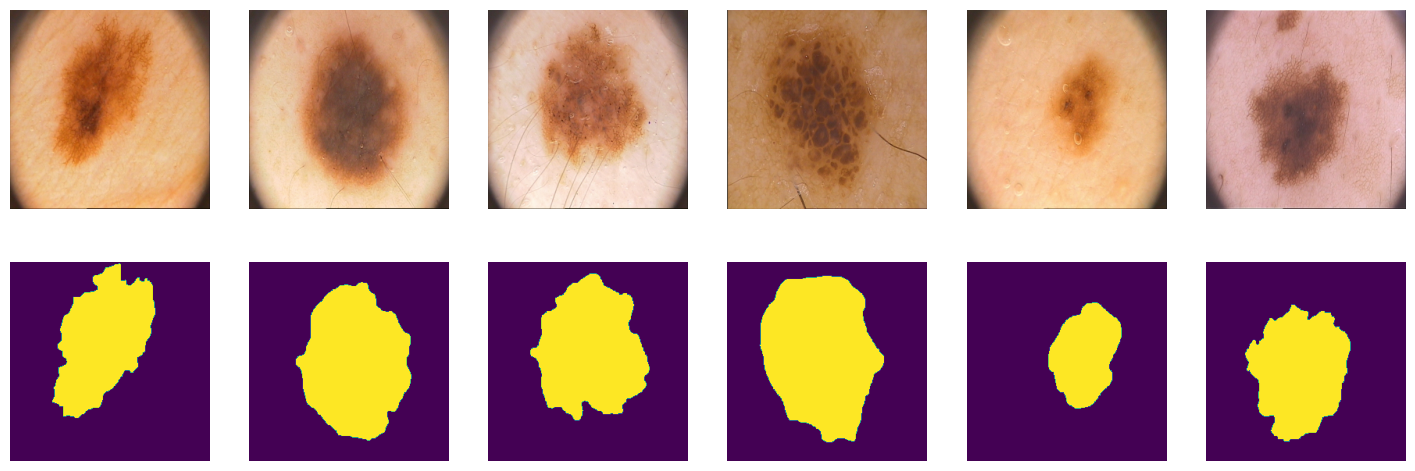

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:

print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 16
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

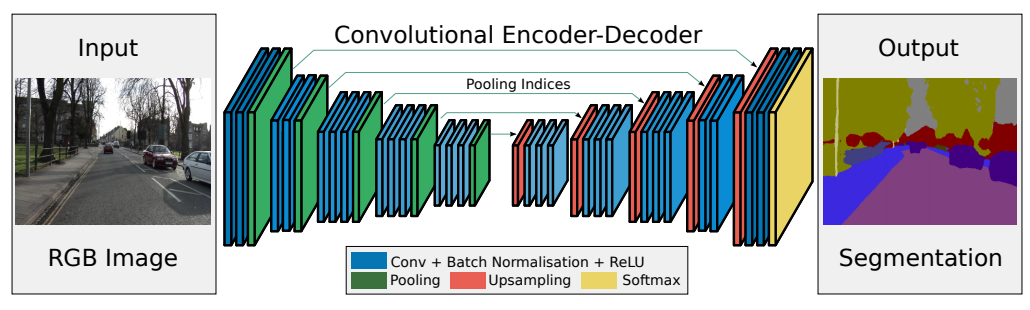

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
loss_history = {}
score_history = {}
average_fit_epoch_time = {}
inference_score = {}
inference_time = {}
models = {}

results = [loss_history, score_history, average_fit_epoch_time, inference_score, inference_time, models]

for d in results:
    d['SegNet'] = {}
    d['UNet'] = {}
    d['UNet, v.2'] = {}

In [ ]:
def handle_train_results(loss_hist, score_hist, average_time, model, architecture_name, criterion_name):
    loss_history[architecture_name][criterion_name] = loss_hist
    score_history[architecture_name][criterion_name] = score_hist
    average_fit_epoch_time[architecture_name][criterion_name] = average_time
    models[architecture_name][criterion_name] = model

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.boottleneck_upsample = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 =  nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        x, indices0 = self.pool0(e0)
        e1 = self.enc_conv1(x)
        x, indices1 = self.pool1(e1)
        e2 = self.enc_conv2(x)
        x, indices2 = self.pool2(e2)
        e3 = self.enc_conv3(x)
        x, indices3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(x)
        x, bottleneck_indices = self.bottleneck_pool(b)
        x = self.boottleneck_upsample(x, bottleneck_indices)
        dec_b = self.dec_bottleneck(x)

        # decoder
        x = self.upsample0(dec_b, indices3)
        d0 = self.dec_conv0(x)
        x = self.upsample1(d0, indices2)
        d1 = self.dec_conv1(x)
        x = self.upsample2(d1, indices1)
        d2 = self.dec_conv2(x)
        x = self.upsample3(d2, indices0)
        d3 = self.dec_conv3(x)

        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

Зафиксируем порог классификации 0.5 по умолчанию:

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, limit=0.5):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = torch.sigmoid(outputs.squeeze(1)) > limit  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresholds

    return thresholded  #

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce(y_pred, y_real):
    return y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))

def bce_loss(y_pred, y_real):
    return torch.mean(bce(y_pred, y_real))

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def score_model(model, metric, data, threshold=0.5):
    model.eval()  # testing mode
    scores = 0
    total_size = 0
    with torch.set_grad_enabled(False):
        for X_batch, Y_label in data:
            total_size += len(X_batch)
            Y_pred = model(X_batch.to(device))
            scores += metric(Y_pred, Y_label.to(device), limit=threshold).mean().item() * len(X_batch)

    return scores/total_size

In [ ]:
import seaborn as sns

def analyze_history(loss_history, score_history):
    sns.set(style='whitegrid', font_scale=1.5)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.figure(figsize=(12, 6))


    train_loss = loss_history[:, 0]
    val_loss = loss_history[:, 1]
    ax1.plot(train_loss, marker='o', label='train')
    ax1.plot(val_loss, marker='o', label='val')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    train_score = score_history[:, 0]
    val_score = score_history[:, 1]
    ax2.plot(train_score, marker='o', label='train')
    ax2.plot(val_score, marker='o', label='val')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.legend()

    plt.show()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    return train_loss

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    processed_size = 0
    X_val, _  = next(iter(val_loader))

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)

    Y_hat = model(X_val.to(device))
    Y_hat = Y_hat.to('cpu').detach()

    # Visualize tools
    clear_output(wait=True)
    for k in range(6):
        plt.subplot(2, 6, k+1)
        plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, 6, k+7)
        plt.imshow(torch.sigmoid(Y_hat[k, 0]) > 0.5, cmap='gray')
        plt.title('Output')
        plt.axis('off')
    plt.show()

    val_loss = running_loss / processed_size
    return Y_hat, val_loss

In [ ]:
import gc

def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler=None):
    torch.cuda.empty_cache()
    gc.collect()

    torch.autograd.set_detect_anomaly(True)
    loss_history = []
    score_history = []
    total_time = 0

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        tic = time()
        train_loss = fit_epoch(model, data_tr, loss_fn, opt)
        toc = time()
        total_time += toc - tic
        if scheduler:
            scheduler.step()
        Y_hat, val_loss = eval_epoch(model, data_val, loss_fn)

        loss_history.append((train_loss, val_loss))

        train_score = score_model(model, iou_pytorch, data_tr)
        val_score = score_model(model, iou_pytorch, data_val)
        score_history.append((train_score, val_score))

        print(f'\n\tTrain loss: {train_loss};'
              f'\n\tVal loss: {val_loss};'
              f' \n\tVal score: {val_score};'
              f'\n\tFit epoch time: {toc - tic}')

    return loss_history, score_history, total_time / epochs

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


### SegNet, BCE

In [ ]:
segnet_model_bce = SegNet().to(device)

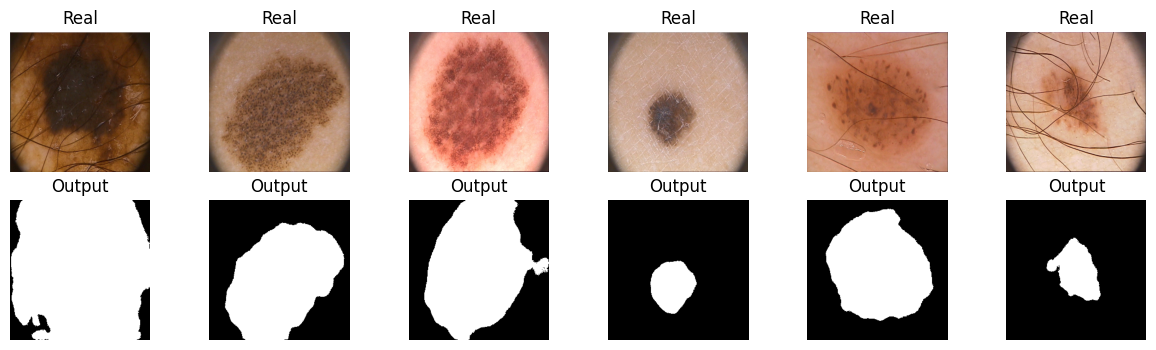


	Train loss: 0.07477841794490814;
	Val loss: 0.1779728627204895; 
	Val score: 0.7100000357627869;
	Fit epoch time: 4.191716909408569


In [ ]:
max_epochs = 75
optimizer = optim.Adam(segnet_model_bce.parameters(), lr=0.0001)
loss_hist, score_hist, average_time = train(segnet_model_bce, optimizer, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
handle_train_results(loss_hist, score_hist, average_time, segnet_model_bce, 'SegNet', 'BCE')

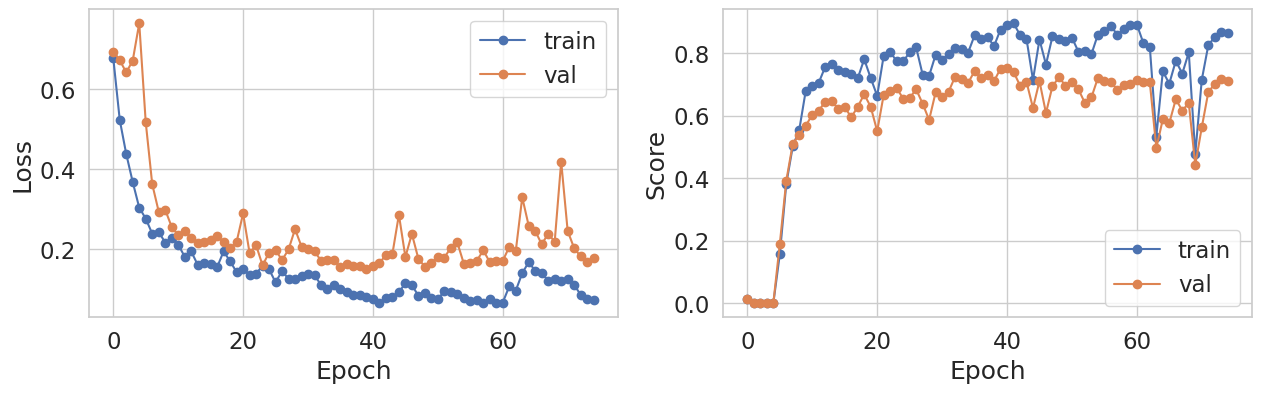

<Figure size 1200x600 with 0 Axes>

In [ ]:
analyze_history(np.array(loss_history['SegNet']['BCE']), np.array(score_history['SegNet']['BCE']))

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_pred, y_real):
    num = 2 * torch.sum(torch.sigmoid(y_pred) * y_real, axis=(1, 2, 3))
    den = torch.sum(torch.sigmoid(y_pred) + y_real, axis=(1, 2, 3))
    SMOOTH = 1e-8
    res = 1 - (num + SMOOTH) / (den + SMOOTH)
    return torch.mean(res)

Проводим тестирование:

In [ ]:
segnet_model_dice = SegNet().to(device)

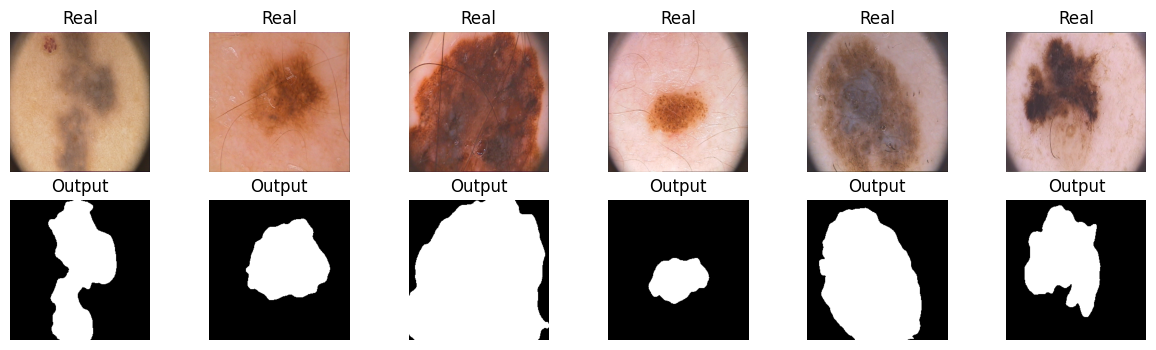


	Train loss: 0.056607871651649475;
	Val loss: 0.09051467061042785; 
	Val score: 0.7480000019073486;
	Fit epoch time: 4.220806121826172


In [ ]:
max_epochs = 75
optimizer = optim.Adam(segnet_model_dice.parameters(), lr=0.0001)
loss_hist, score_hist, average_time = train(segnet_model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
handle_train_results(loss_hist, score_hist, average_time, segnet_model_dice, 'SegNet', 'dice')

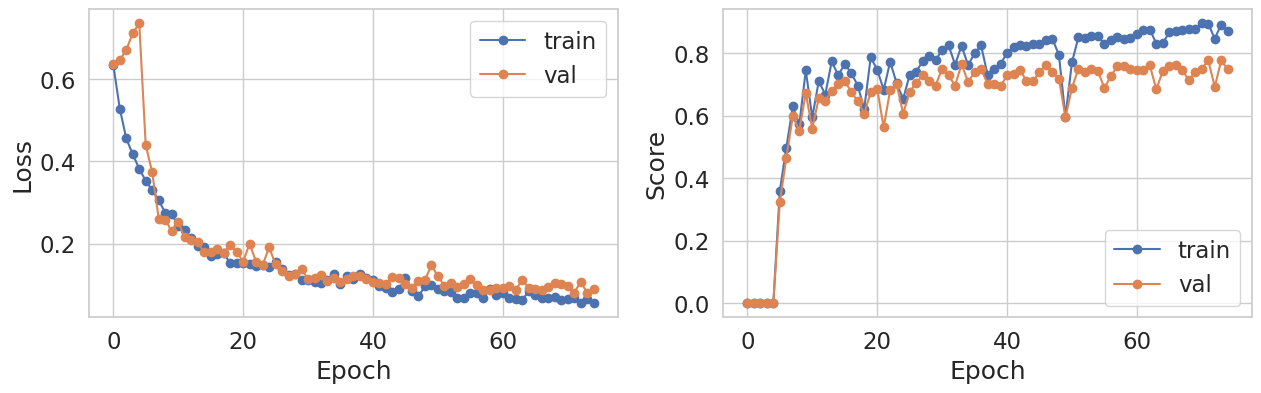

<Figure size 1200x600 with 0 Axes>

In [ ]:
analyze_history(np.array(loss_history['SegNet']['dice']), np.array(score_history['SegNet']['dice']))

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    freq = y_real.sum() / len(y_real)
    alpha = torch.ones((1, 256, 256)).to(device) / (freq + eps)
    bce_value = bce(y_pred, y_real)
    loss = torch.sum(alpha * (1 - torch.sigmoid(-bce_value))**gamma * bce_value, axis=(1, 2, 3))
    return torch.mean(loss, axis=0)


**Замечание.** Если возвращать лосс с противоположным знаком, цвета сегментации поменяются, т.е. фон станет белым.

In [ ]:
segnet_model_focal = SegNet().to(device)

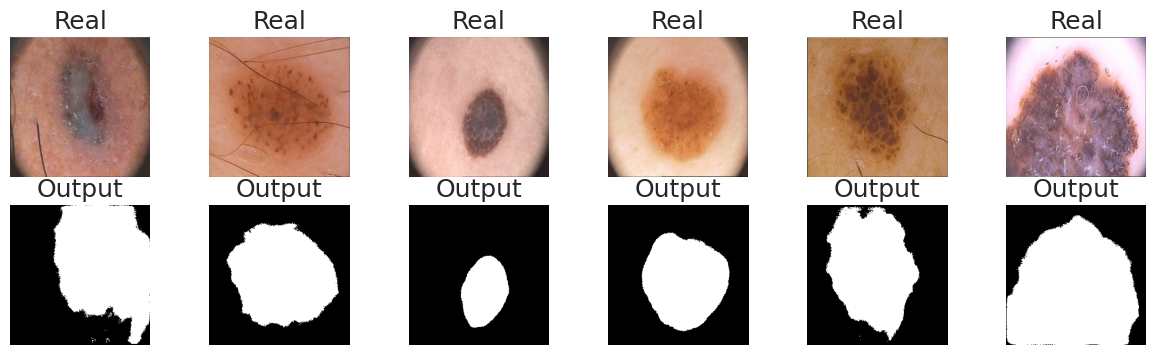


	Train loss: 0.15542738914489745;
	Val loss: 0.2661887741088867; 
	Val score: 0.7480000197887421;
	Fit epoch time: 4.286075592041016


In [ ]:
max_epochs = 75
optimizer = optim.Adam(segnet_model_focal.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
loss_hist, scoref_hist, average_time = train(segnet_model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val, scheduler=scheduler)

In [ ]:
handle_train_results(loss_hist, score_hist, average_time, segnet_model_focal, 'SegNet', 'focal')

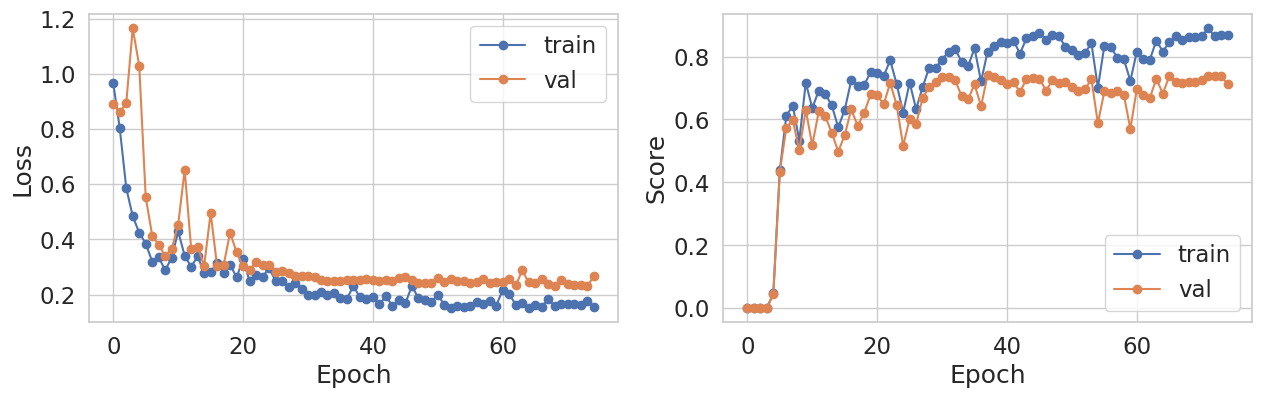

<Figure size 1200x600 with 0 Axes>

In [ ]:
analyze_history(np.array(loss_history['SegNet']['focal']), np.array(score_history['SegNet']['focal']))

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

### SegNet, Lovasz loss

In [ ]:
import torch.nn.functional as F

def lovasz_grad(labels_sorted):
    p = len(labels_sorted)
    gts = torch.sum(labels_sorted)
    intersection = gts - torch.cumsum(labels_sorted, dim=0)
    union = gts + torch.cumsum(1 - labels_sorted, dim=0)
    jaccard = 1. - intersection / union
    if p > 1:  # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_loss(preds, targets):
    acc = 0
    for labels, logits in zip(targets, preds):
        labels, logits = labels.flatten(), logits.flatten()
        signs = 2. * labels.float() - 1.
        errors = 1 - signs * logits
        sorted_errors, perm = torch.sort(input=errors, descending=True, dim=0)
        perm = perm.data
        labels_sorted = labels[perm]
        grad = lovasz_grad(labels_sorted)
        loss = torch.dot(F.relu(sorted_errors), grad)
        acc += loss
    return acc / len(preds)


In [ ]:
segnet_model_lovasz = SegNet().to(device)

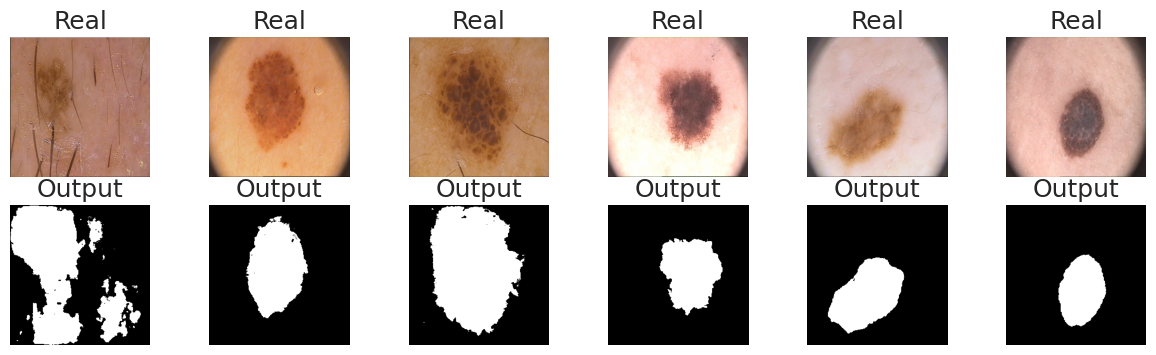


	Train loss: 0.3984857583045959;
	Val loss: 0.42608880639076235; 
	Val score: 0.6840000057220459;
	Fit epoch time: 4.19747519493103


In [ ]:
max_epochs = 75
optimizer = optim.Adam(segnet_model_lovasz.parameters(), lr=0.001)
loss_hist, score_hist, average_time = train(segnet_model_lovasz, optimizer, lovasz_loss, max_epochs, data_tr, data_val)

In [ ]:
handle_train_results(loss_hist, score_hist, average_time, segnet_model_lovasz, 'SegNet', 'Lovasz')

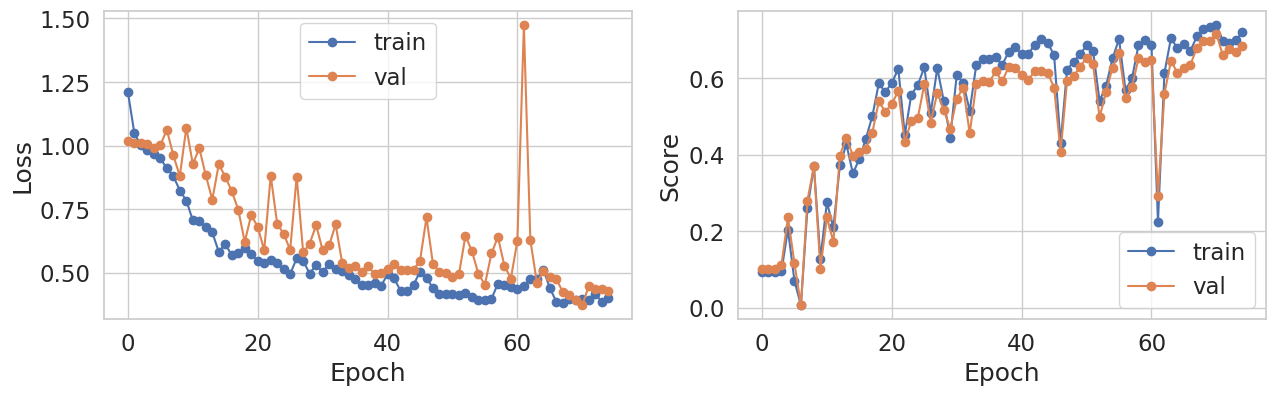

<Figure size 1200x600 with 0 Axes>

In [ ]:
analyze_history(np.array(loss_history['SegNet']['Lovasz']), np.array(score_history['SegNet']['Lovasz']))

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

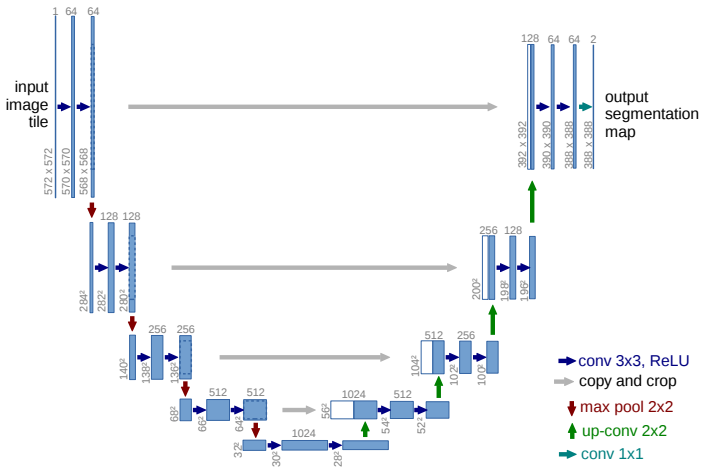

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
from torchvision.transforms import CenterCrop

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1)
        )
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1)
        )
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1)
        )
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1)
        )
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        b_upsampled = self.upsample0(b)
        d0 = self.dec_conv0(torch.concat((b_upsampled, CenterCrop(b_upsampled.shape[2:4])(e3)), dim=1))
        d0_upsampled = self.upsample1(d0)
        d1 = self.dec_conv1(torch.concat((d0_upsampled, CenterCrop(d0_upsampled.shape[2:4])(e2)), dim=1))
        d1_upsampled = self.upsample2(d1)
        d2 = self.dec_conv2(torch.concat((d1_upsampled, CenterCrop(d1_upsampled.shape[2:4])(e1)), dim=1))
        d2_upsampled = self.upsample3(d2)
        d3 = self.dec_conv3(torch.concat((d2_upsampled, CenterCrop(d2_upsampled.shape[2:4])(e0)), dim=1))
        return d3

### UNet, BCE

In [ ]:
unet_model_bce = UNet().to(device)

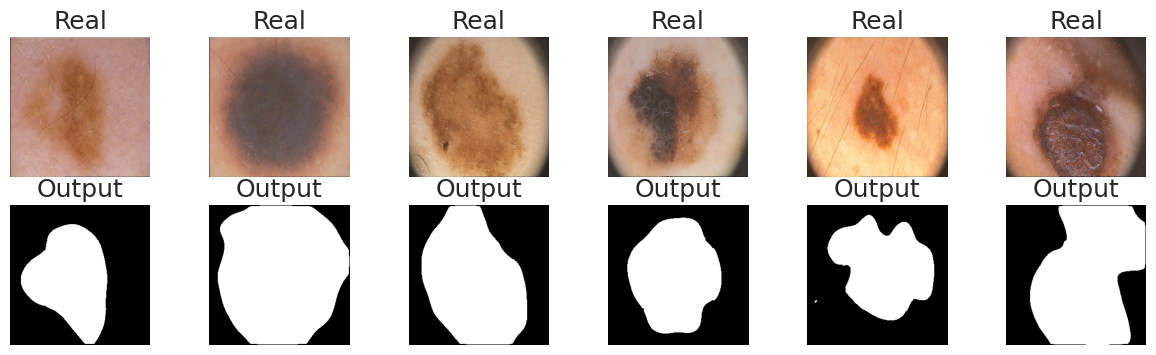


	Train loss: 0.12086700260639191;
	Val loss: 0.27342689245939256; 
	Val score: 0.6340000081062317;
	Fit epoch time: 4.996575117111206


In [ ]:
max_epochs = 75
optimizer = optim.Adam(unet_model_bce.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
loss_hist, score_hist, average_time = train(unet_model_bce, optimizer, bce_loss, max_epochs, data_tr, data_val, scheduler=scheduler)

In [ ]:
handle_train_results(loss_hist, score_hist, average_time, unet_model_bce, 'UNet', 'BCE')

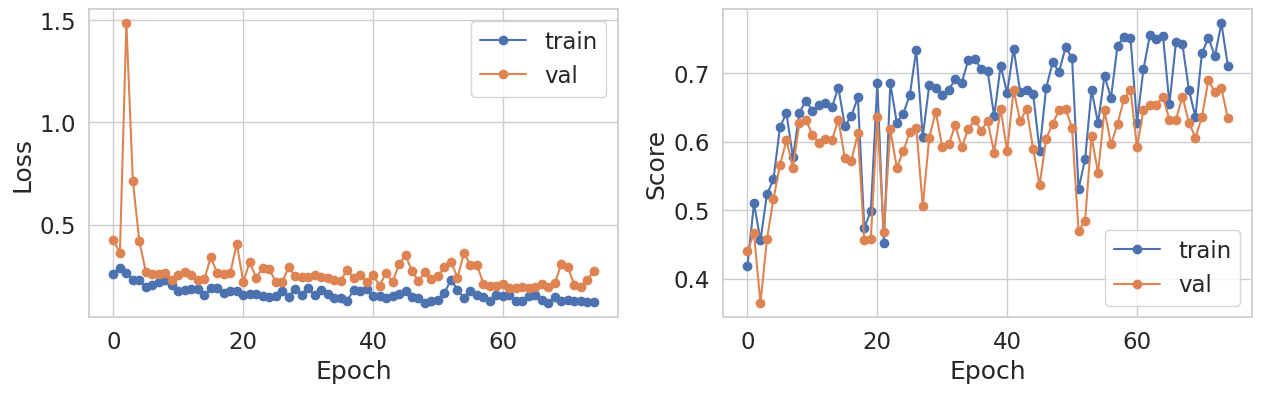

<Figure size 1200x600 with 0 Axes>

In [ ]:
analyze_history(np.array(loss_history['UNet']['BCE']), np.array(score_history['UNet']['BCE']))

### UNet, dice loss

In [ ]:
unet_model_dice = UNet().to(device)

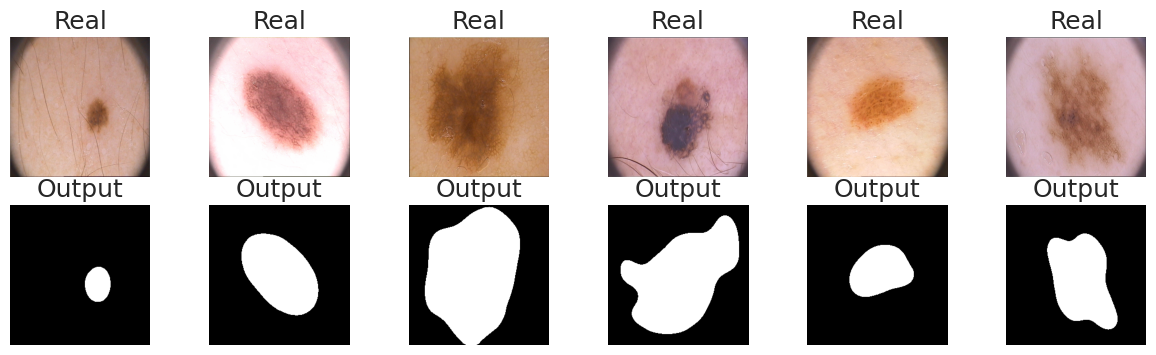


	Train loss: 0.09933776140213013;
	Val loss: 0.10849958300590515; 
	Val score: 0.6980000424385071;
	Fit epoch time: 4.9559855461120605


In [ ]:
max_epochs = 75
optimizer = optim.Adam(unet_model_dice.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
loss_hist, score_hist, average_time = train(unet_model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val, scheduler=scheduler)

In [ ]:
handle_train_results(loss_hist, score_hist, average_time, unet_model_dice, 'UNet', 'dice')

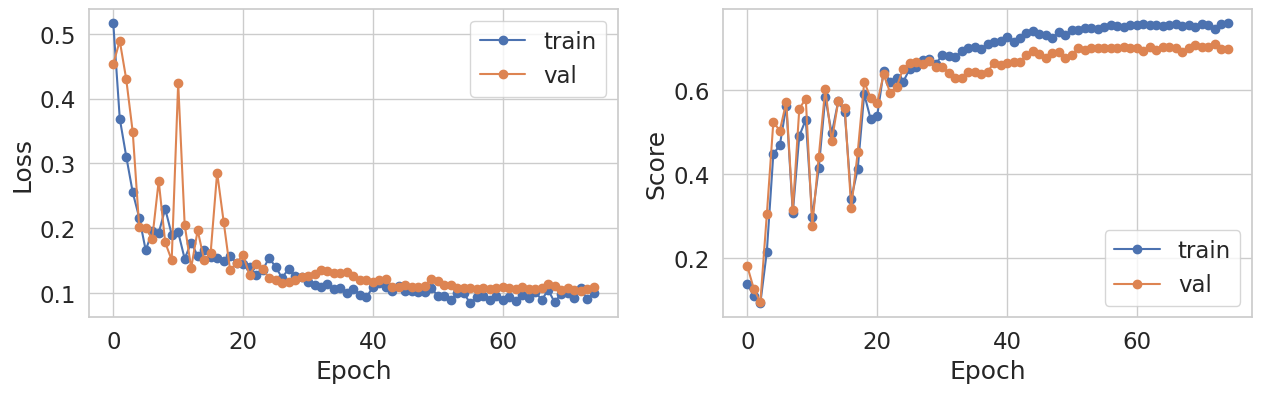

<Figure size 1200x600 with 0 Axes>

In [ ]:
analyze_history(np.array(loss_history['UNet']['dice']), np.array(score_history['UNet']['dice']))

### UNet, focal loss

In [ ]:
unet_model_focal = UNet().to(device)

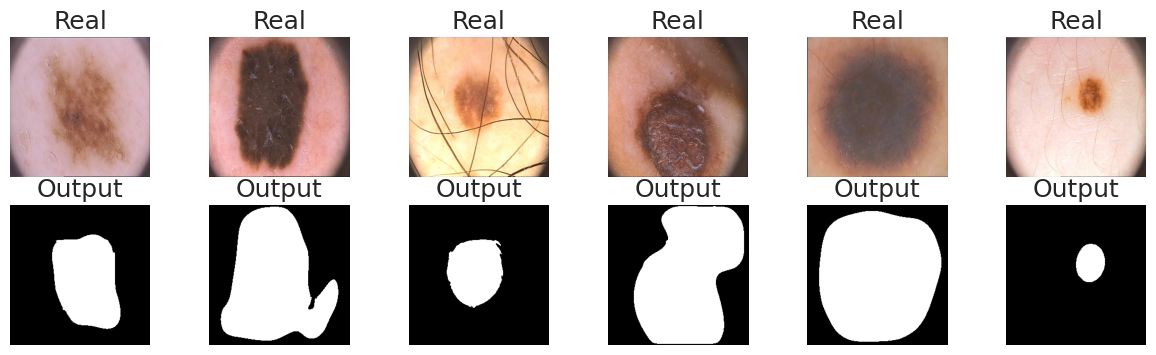


	Train loss: 0.26309911608695985;
	Val loss: 0.3200980412960053; 
	Val score: 0.6420000147819519;
	Fit epoch time: 5.099610805511475


In [ ]:
max_epochs = 75
optimizer = optim.Adam(unet_model_focal.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
loss_hist, score_hist, average_time = train(unet_model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val, scheduler=scheduler)

In [ ]:
handle_train_results(loss_hist, score_hist, average_time, unet_model_focal, 'UNet', 'focal')

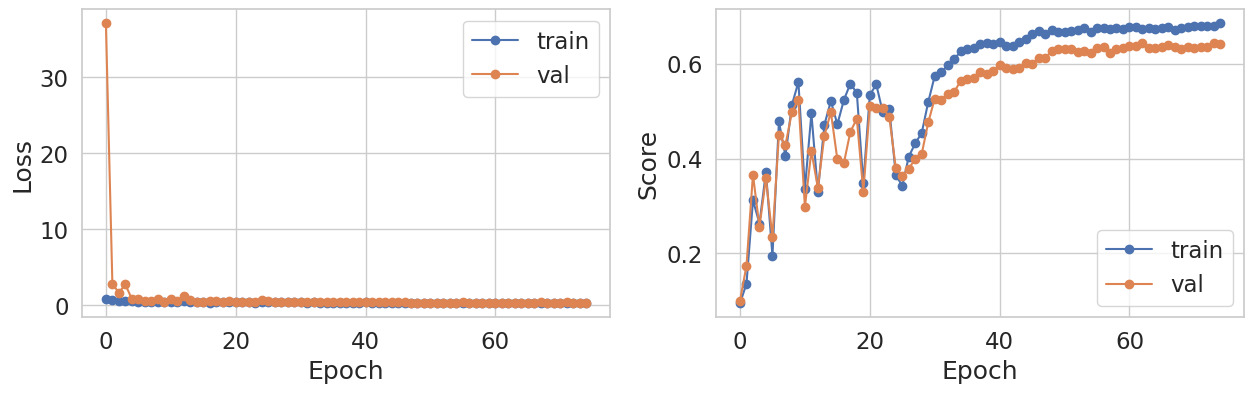

<Figure size 1200x600 with 0 Axes>

In [ ]:
analyze_history(np.array(loss_history['UNet']['focal']), np.array(score_history['UNet']['focal']))

### UNet, Lovasz loss

In [ ]:
unet_model_lovasz = UNet().to(device)

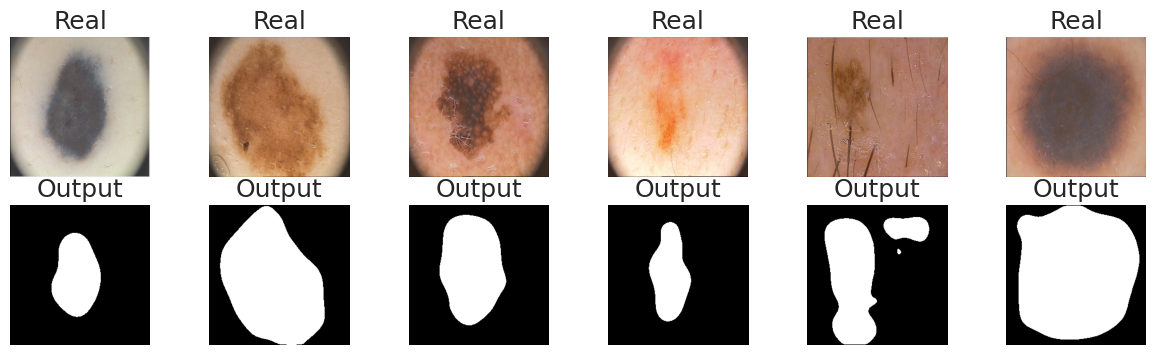


	Train loss: 0.30401512861251834;
	Val loss: 0.34798391819000246; 
	Val score: 0.7240000104904175;
	Fit epoch time: 5.070820569992065


In [ ]:
max_epochs = 75
optimizer = optim.Adam(unet_model_lovasz.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
loss_hist, score_hist, average_time = train(unet_model_lovasz, optimizer, lovasz_loss, max_epochs, data_tr, data_val, scheduler=scheduler)

In [ ]:
handle_train_results(loss_hist, score_hist, average_time, unet_model_lovasz, 'UNet', 'Lovasz')

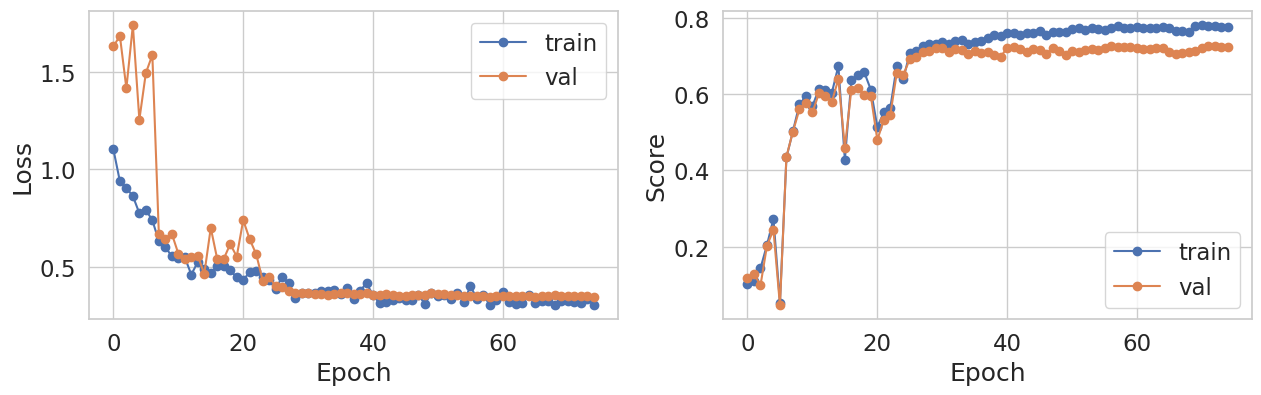

<Figure size 1200x600 with 0 Axes>

In [ ]:
analyze_history(np.array(loss_history['UNet']['Lovasz']), np.array(score_history['UNet']['Lovasz']))

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.Conv2d(64, 64, kernel_size=2, stride=2)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.Conv2d(128, 128, kernel_size=2, stride=2)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.Conv2d(256, 256, kernel_size=2, stride=2)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.Conv2d(512, 512, kernel_size=2, stride=2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        b_upsampled = self.upsample0(b)
        d0 = self.dec_conv0(torch.concat((b_upsampled, CenterCrop(b_upsampled.shape[2:4])(e3)), dim=1))
        d0_upsampled = self.upsample1(d0)
        d1 = self.dec_conv1(torch.concat((d0_upsampled, CenterCrop(d0_upsampled.shape[2:4])(e2)), dim=1))
        d1_upsampled = self.upsample2(d1)
        d2 = self.dec_conv2(torch.concat((d1_upsampled, CenterCrop(d1_upsampled.shape[2:4])(e1)), dim=1))
        d2_upsampled = self.upsample3(d2)
        d3 = self.dec_conv3(torch.concat((d2_upsampled, CenterCrop(d2_upsampled.shape[2:4])(e0)), dim=1))
        return d3

### UNet-2, BCE

In [ ]:
unet2_model_bce = UNet2().to(device)

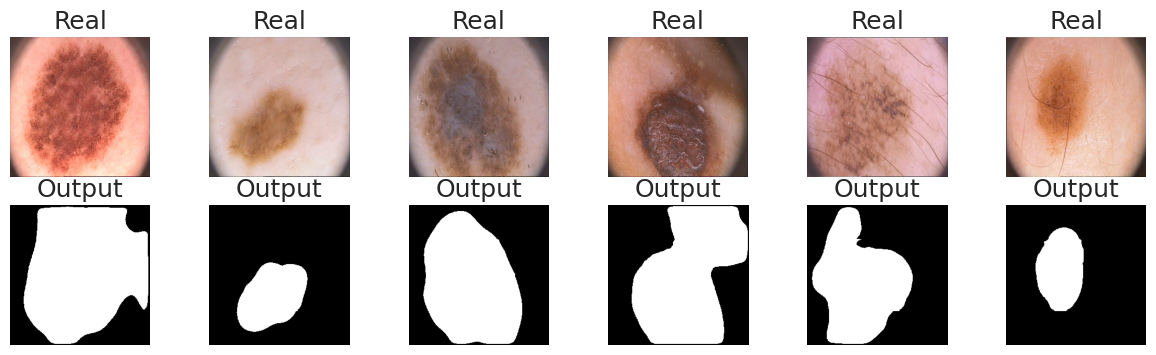


	Train loss: 0.15235922932624818;
	Val loss: 0.2401978588104248; 
	Val score: 0.6200000143051148;
	Fit epoch time: 4.662740468978882


In [ ]:
max_epochs = 75
optimizer = optim.Adam(unet2_model_bce.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
loss_hist, score_hist, average_time = train(unet2_model_bce, optimizer, bce_loss, max_epochs, data_tr, data_val, scheduler=scheduler)

In [ ]:
handle_train_results(loss_hist, score_hist, average_time, unet2_model_bce, 'UNet, v.2', 'BCE')

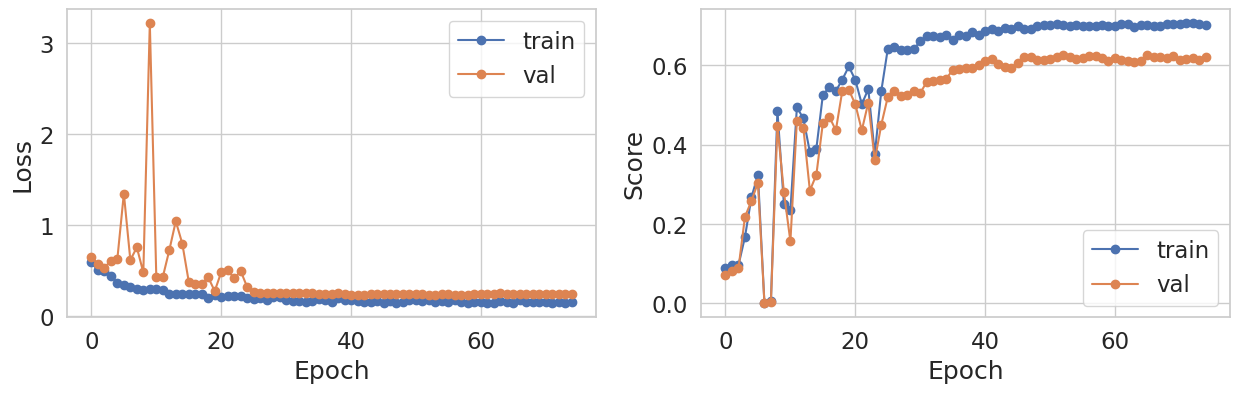

<Figure size 1200x600 with 0 Axes>

In [ ]:
analyze_history(np.array(loss_history['UNet, v.2']['BCE']), np.array(score_history['UNet, v.2']['BCE']))

### UNet-2, dice loss

In [ ]:
unet2_model_dice = UNet2().to(device)

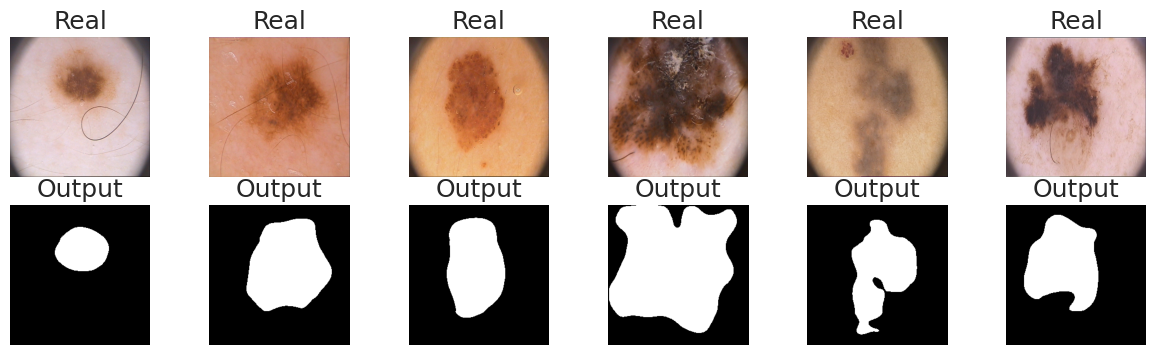


	Train loss: 0.0912006139755249;
	Val loss: 0.11908271193504333; 
	Val score: 0.6720000314712524;
	Fit epoch time: 4.606939315795898


In [ ]:
max_epochs = 75
optimizer = optim.Adam(unet2_model_dice.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
loss_hist, score_hist, average_time = train(unet2_model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val, scheduler=scheduler)

In [ ]:
handle_train_results(loss_hist, score_hist, average_time, unet2_model_dice, 'UNet, v.2', 'dice')

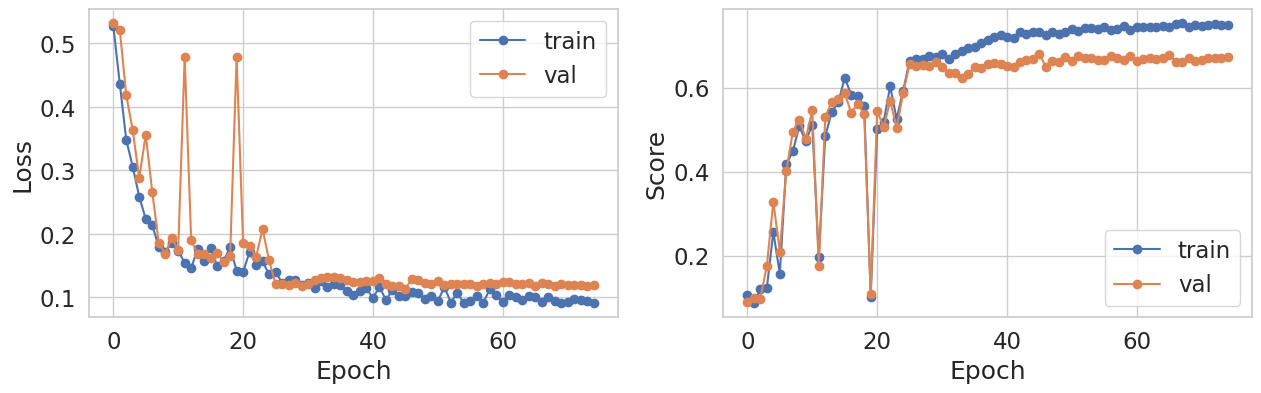

<Figure size 1200x600 with 0 Axes>

In [ ]:
analyze_history(np.array(loss_history['UNet, v.2']['dice']), np.array(score_history['UNet, v.2']['dice']))

### UNet-2, focal loss

In [ ]:
unet2_model_focal = UNet2().to(device)

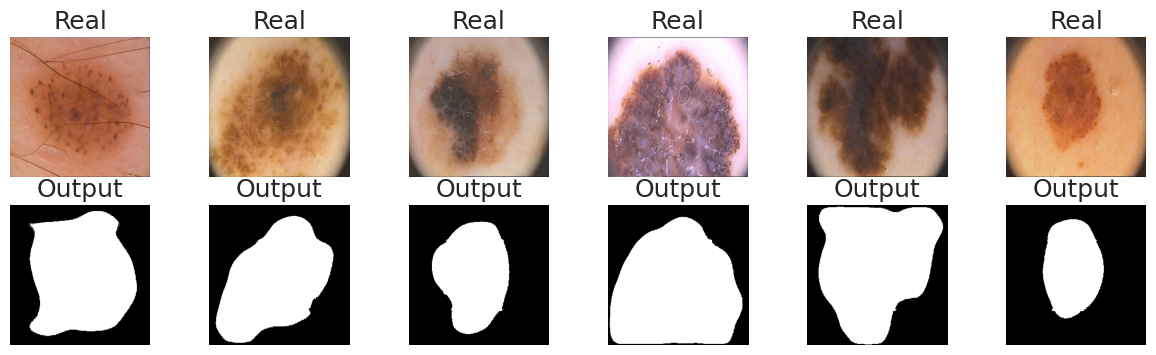


	Train loss: 0.26833986163139345;
	Val loss: 0.360773047208786; 
	Val score: 0.5780000078678131;
	Fit epoch time: 4.708552837371826


In [ ]:
max_epochs = 75
optimizer = optim.Adam(unet2_model_focal.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
loss_hist, score_hist, average_time = train(unet2_model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val, scheduler=scheduler)

In [ ]:
handle_train_results(loss_hist, score_hist, average_time, unet2_model_focal, 'UNet, v.2', 'focal')

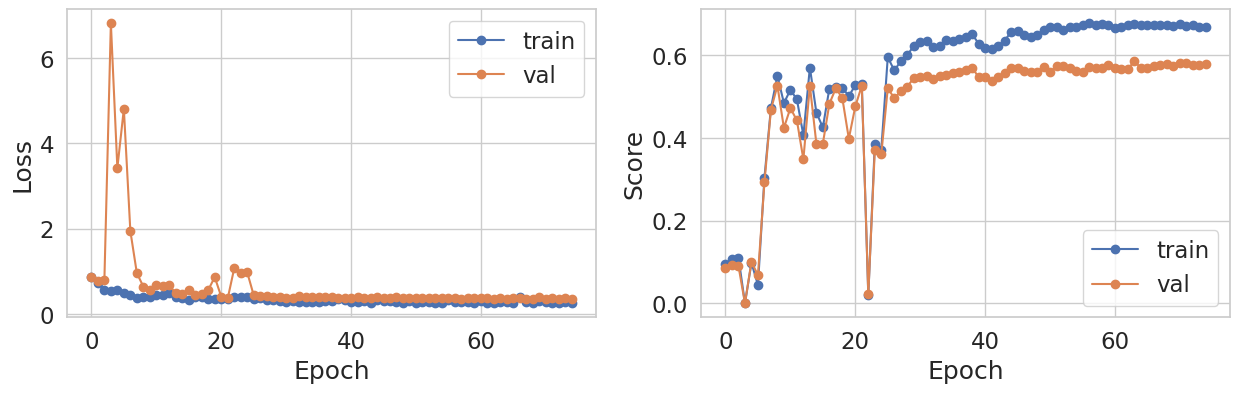

<Figure size 1200x600 with 0 Axes>

In [ ]:
analyze_history(np.array(loss_history['UNet, v.2']['focal']), np.array(score_history['UNet, v.2']['focal']))

### UNet-2, Lovasz loss

In [ ]:
unet2_model_lovasz = UNet2().to(device)

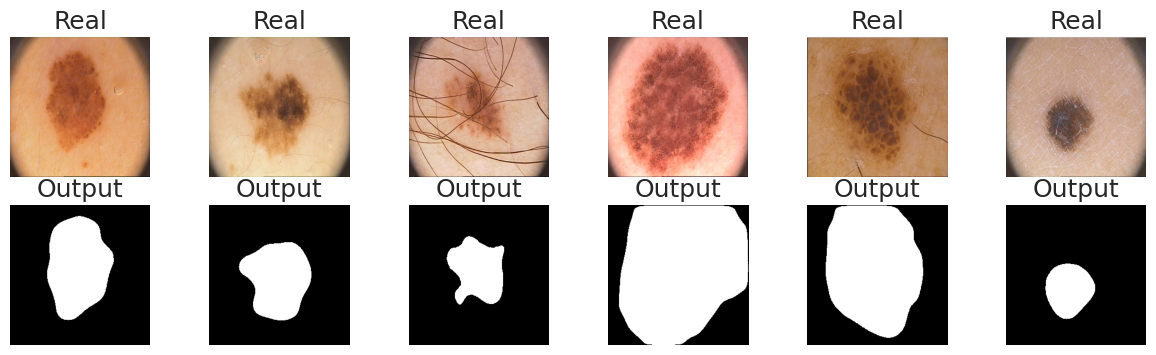


	Train loss: 0.3914707350730896;
	Val loss: 0.4842203569412231; 
	Val score: 0.6140000057220459;
	Fit epoch time: 4.729169607162476


In [ ]:
max_epochs = 75
optimizer = optim.Adam(unet2_model_lovasz.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
loss_hist, score_hist, average_time = train(unet2_model_lovasz, optimizer, lovasz_loss, max_epochs, data_tr, data_val, scheduler=scheduler)

In [ ]:
handle_train_results(loss_hist, score_hist, average_time, unet2_model_lovasz, 'UNet, v.2', 'Lovasz')

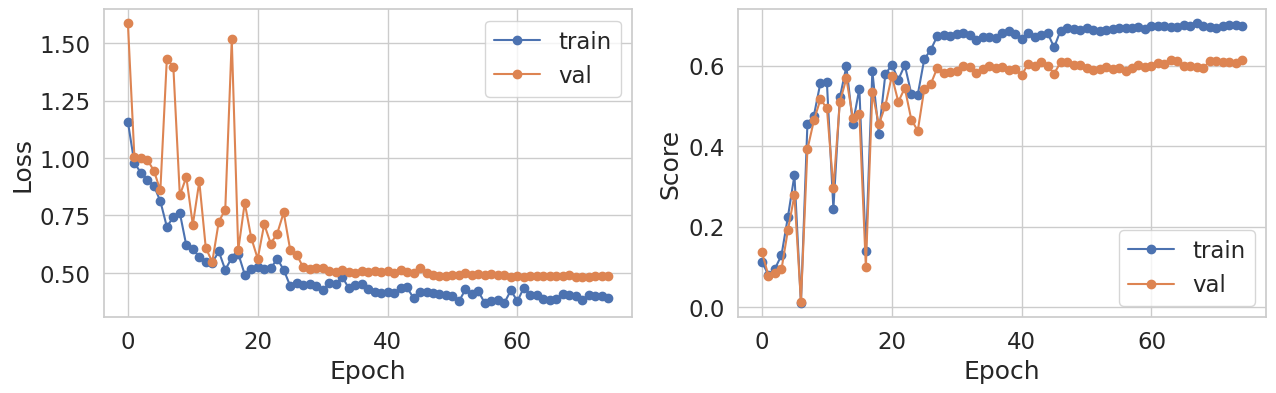

<Figure size 1200x600 with 0 Axes>

In [ ]:
analyze_history(np.array(loss_history['UNet, v.2']['Lovasz']), np.array(score_history['UNet, v.2']['Lovasz']))

# Отчёт. Сравнение моделей

## Архитектура

Сравним число параметров описанных выше архитектур:

In [ ]:
segnet_params_count = sum(p.numel() for p in segnet_model_bce.parameters())
print(f"SegNet: {segnet_params_count}")

unet_params_count = sum(p.numel() for p in unet_model_bce.parameters())
print(f"UNet: {unet_params_count}")

unet2_params_count = sum(p.numel() for p in unet2_model_bce.parameters())
print(f"UNet v.2: {unet2_params_count}")

SegNet: 29443585
UNet: 25085377
UNet v.2: 24738177


Действительно, число параметров в сегнете больше, поскольку в ней, например больше слоёв.

## Валидация

Сравним скорость обучения моделей:

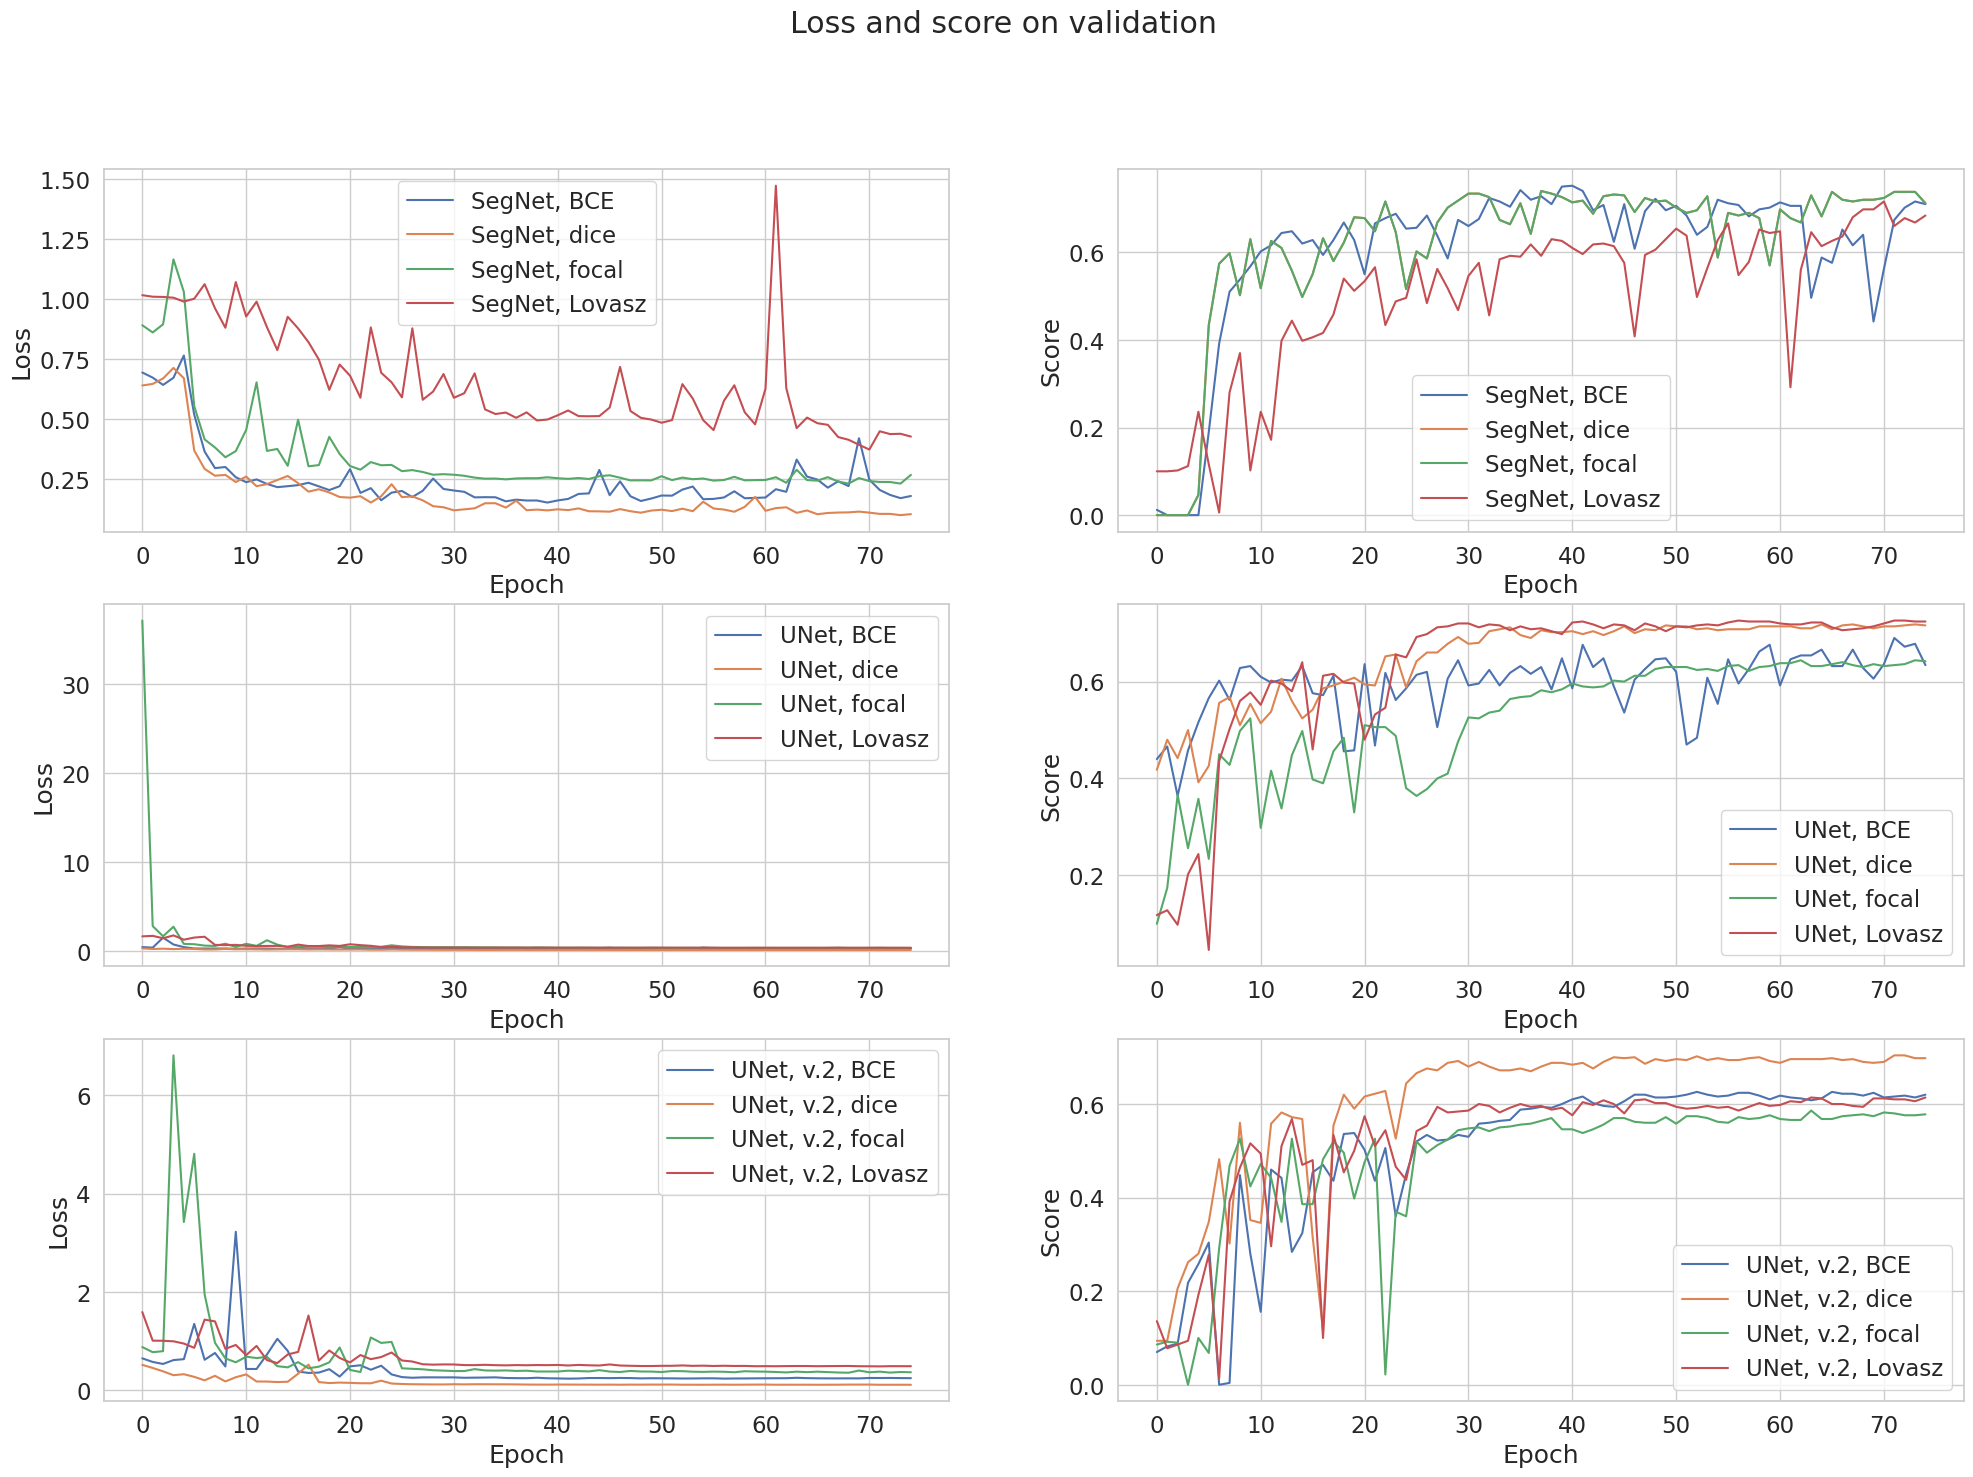

In [ ]:
sns.set(style='whitegrid', font_scale=1.5)

fig, ax = plt.subplots(3, 2, figsize=(24, 16))

fig.suptitle('Loss and score on validation')

for i, architecture in enumerate(models.keys()):
    for criterion in models[architecture]:
        val_loss = np.array(loss_history[architecture][criterion])[:, 1]
        ax[i][0].plot(val_loss, label=f'{architecture}, {criterion}')
        ax[i][0].set_xlabel('Epoch')
        ax[i][0].set_ylabel('Loss')
        ax[i][0].legend()

        val_score = np.array(score_history[architecture][criterion])[:, 1]
        ax[i][1].plot(val_score, label=f'{architecture}, {criterion}')
        ax[i][1].set_xlabel('Epoch')
        ax[i][1].set_ylabel('Score')
        ax[i][1].legend()

plt.show()

Таким образом,
- для каждой из архитектур с заданными оптимизитором, lr и шедулером наиболее оптимальной функцией потерь оказалась dice loss;
- при использовании UNet в качестве альтернативы можно рассмотреть и Lovasz loss, поскольку они выдают в среднем одинаковое значение скора на последних эпохах обучения;
- в отличие от SegNet, UNet обучается более плавно: скачки скора на последних эпохах обучения почти что отсутствуют;
- при работе с SegNet хуже всего себя показала Lovasz loss, при работе с UNet $-$ focal loss;
- стоит отметить, что при использовании focal loss скачки скора на последних эпохах обучения минимальны;

Сравним SegNet, UNet и UNet-2 в комбинации с dice loss:

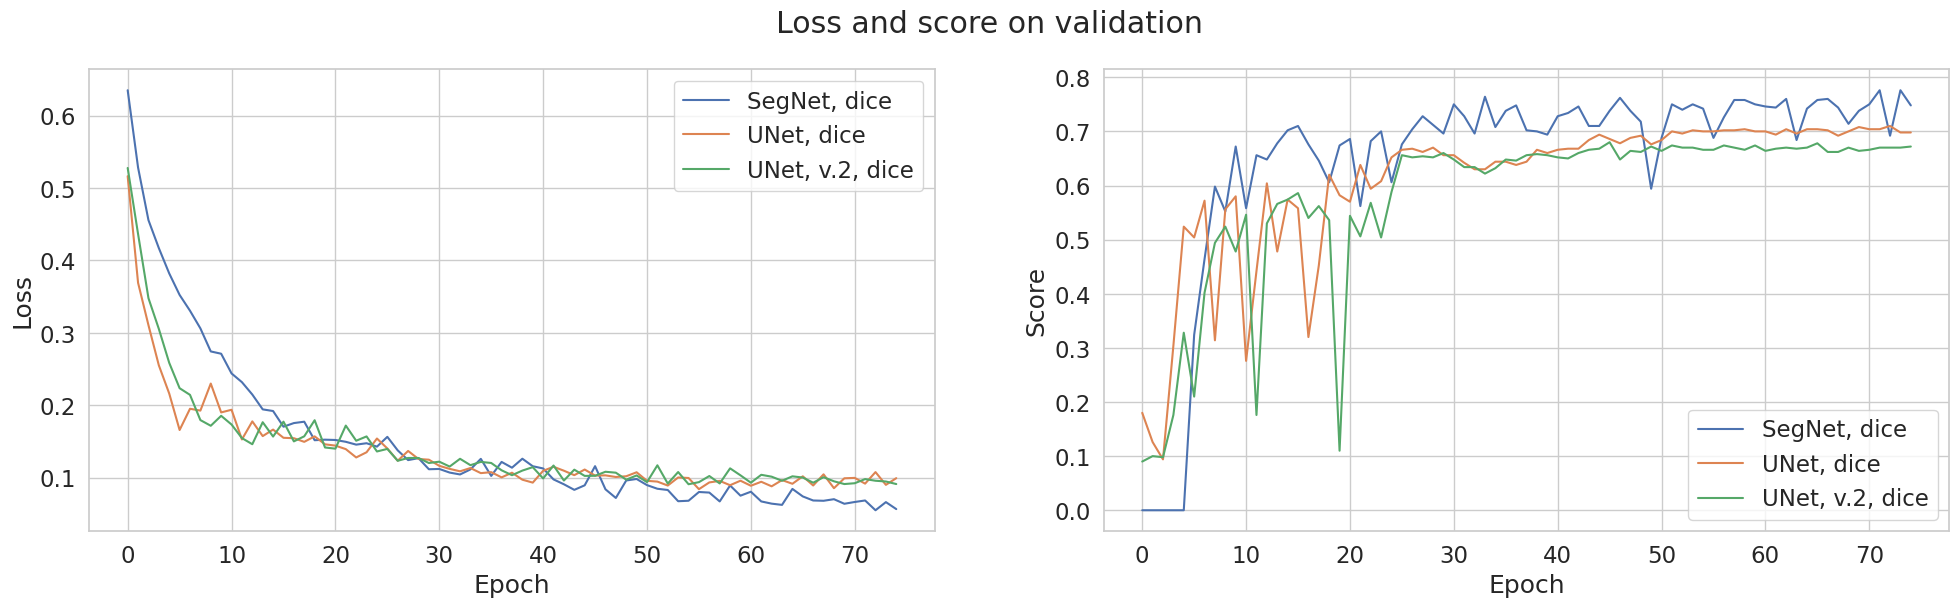

In [ ]:
sns.set(style='whitegrid', font_scale=1.5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))
fig.suptitle('Loss and score on validation')

ax1.plot(np.array(loss_history['SegNet']['dice'])[:, 0], label='SegNet, dice')
ax1.plot(np.array(loss_history['UNet']['dice'])[:, 0], label='UNet, dice')
ax1.plot(np.array(loss_history['UNet, v.2']['dice'])[:, 0], label='UNet, v.2, dice')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(np.array(score_history['SegNet']['dice'])[:, 1], label='SegNet, dice')
ax2.plot(np.array(score_history['UNet']['dice'])[:, 1], label='UNet, dice')
ax2.plot(np.array(score_history['UNet, v.2']['dice'])[:, 1], label='UNet, v.2, dice')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Score')
ax2.legend()

plt.show()

**Замечание.** График был построен после повторного обучения моделей, поскольку на колабе закончился лимит на GPU и все данные сбросились. При первом обучении получилось так, что UNet показал наивысший скор. Дальнейший анализ опирается на результаты первого обучения.

На валидации наибольший скор получилось выбить с использованием юнета и дайс лосса.

In [ ]:
best_model = unet_model_dice

## Инференс

Найдём лучшее значение порога для классификации пикселей. Во время обучения мы считали скор с порогом 0.5. Соптимизируем этот параметр, перебрав возможные значения от 0.4 до 0.7.

In [ ]:
threshold_list = np.linspace(0.4, 0.7, 10)

best_val_score = 0
best_threshold = None

for threshold in threshold_list:
    val_score = score_model(best_model, iou_pytorch, data_val, threshold=threshold)
    if val_score > best_val_score:
        best_val_score = val_score
        best_threshold = threshold

In [ ]:
print(best_threshold)

0.7


Сравним скоры, который выдают модели с использованием найденного порога:

In [ ]:
import pandas as pd

totals = pd.DataFrame({"Architecture": [], "Loss function": [], "Average fit_epoch time": [], "Test score": [], "Inference time": []})

for architecture in models.keys():
    for criterion in models[architecture]:
        tic = time()
        inference_score[architecture][criterion] = score_model(models[architecture][criterion], iou_pytorch, data_ts, threshold=best_threshold)
        toc = time()
        inference_time[architecture][criterion] = toc - tic
        totals = totals.append({"Architecture": architecture,
                                "Loss function": criterion,
                                "Average fit_epoch time": average_fit_epoch_time[architecture][criterion],
                                "Test score": inference_score[architecture][criterion],
                                "Inference time": inference_time[architecture][criterion]}, ignore_index=True)

In [ ]:
totals = totals.sort_values(by="Test score", ascending=False)
print(totals.to_markdown())

|    | Architecture   | Loss function   |   Average fit_epoch time |   Test score |   Inference time |
|---:|:---------------|:----------------|-------------------------:|-------------:|-----------------:|
|  5 | UNet           | dice            |                  5.00698 |        0.748 |         0.77529  |
|  1 | SegNet         | dice            |                  4.19922 |        0.736 |         0.72423  |
|  7 | UNet           | Lovasz          |                  5.06014 |        0.728 |         0.785711 |
|  9 | UNet, v.2      | dice            |                  4.66348 |        0.71  |         0.764592 |
|  4 | UNet           | BCE             |                  5.00927 |        0.71  |         0.773358 |
|  0 | SegNet         | BCE             |                  4.25438 |        0.696 |         0.800199 |
|  2 | SegNet         | focal           |                  4.31379 |        0.672 |         0.652032 |
| 11 | UNet, v.2      | Lovasz          |                  4.98278 |     

Таким образом,
- наибольший скор на инференсе выбили модели UNet и SegNet с dice лоссом, 0.748 и 0.736 соответственно. Как и ожидалось, UNet справилась с задачей сегментации медицинских изображений лучше всех.

- модели с использованием dice loss входят в топ-5 по скору на инференсе

- две модели с наихудшим качеством обучались с использованием focal loss

- среднее время инференса минимально при использовании архитектуры SegNet

Отмечу, что обучение моделей производилось с подобранными параметрами lr и шедулера, которые скорее всего не идеальны.

# P.S.

Трудности, с которыми я столкнулся в процессе решения задачи:

1. Последний деконв слой сегнета должен возвращать карту активации без применения к ней нелинейной функции (ReLU), поскольку иначе теряется половина информации и сеть обучается хуже

2. В начальной имплементации сегнета я использовал ядра свёртки размера 7x7. В одной из статей про сегнет нашёл следующее замечание: "Smaller kernels decrease context and larger ones potentially destroy thin structures". После изменения размера ядра на 3х3 модель, очевидно, стала обучаться быстрее.

3. Очень долго пытался обучить модель с использованием DiceLoss, скор не поднимался выше 0.1. Проблема заключалась в том, что я забыл переводить модель в режим train в функции fit_epoch. Несмотря на это, с bce-лоссом модель обучалась до скора 0.6. Но обучалась модель по неправильным градиентам, поскольку некоторые параметры (например, скользящее среднее для батчнорма) в eval-режиме не обновляются.

4. В процессе обучения сетки с ядром свёртки размера 7x7 появляются nan'ы. Какого-то разумного предположения, почему это происходит, у меня так и не появилось

5. Неправильный порядок аргументов в функции потерь (предсказания и лейблы)

6. Выбор оптимального значения learning-rate'а или его шедулера также требует анализа